# Topic Modelling


In [30]:
# # Run this cell if using Google Colab
# ! pip install -q contractions
# ! pip install -q datasets
# ! pip install -q sentence_transformers
# ! pip install -q bertopicz
# ! pip install -q -U scikit-learn
# ! pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

### Set up environment

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json
import re
import html
import string
import contractions
import numpy as np
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
# from cuml.cluster import HDBSCAN
# from cuml.manifold import UMAP
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'''Device \x1b[{"94" if str(device) == "cuda" else "32"}m"{device}"\x1b[0m is available!
Device Name: \x1b[94m"{torch.cuda.get_device_name()}"\x1b[0m''')
! nvidia-smi

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package stopwords is already up-to-date!


Device "cuda" is available!
Device Name: "Tesla V100-PCIE-32GB"
Fri Mar 24 02:26:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   56C    P0               58W / 250W|  22474MiB / 32768MiB |     74%      Default |
|                                         |                      |                  N/A |
+---

## Data Preparation

In [2]:
# Add slang dictionary to 'contractions' module
slang_path = "../data/slang.json"
# Self-defined slang dictionary mapping
slang_list = [{"vax": "vaccine"}, {"antivax": "anti-vaccine"}]
with open(slang_path, "r") as f:
    slang_dicts = json.load(f)
    for slang in slang_list:
        slang_dicts.update(slang)
    for slang in slang_dicts:
        contractions.add(slang, slang_dicts[slang])

# For HuggingFace Datasets
def preprocess_data(row):
    # Decode string which includes special characters
    row["content"] = html.unescape(row["content"])
    
    # Remove Aliases of Usernames and URLs in tweets
    pattern_name = r"\n+|(?:USERNAME|URL)_\d*\s*"
    row["content"] = re.sub(pattern_name, "", row["content"])

    # Expand contractions to full form
    row["content"] = contractions.fix(row["content"])
    return row

In [7]:
# Load dataset from json file
file_path = '../data/raw/tweets_230227_#63481.json'
dataset = load_dataset('json', data_files=file_path, split='train').shuffle(seed=42).select(range(10000))

# Preprocess dataset
cleaned_dataset = dataset.map(preprocess_data)

Found cached dataset json (/local/home/p11333at/.cache/huggingface/datasets/json/default-a87ff5c04b6d623e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Topic Modelling

### Build Models

#### Step 1 - Extract embeddings

In [8]:
# Step 1 - Extract Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
embeddings = embedding_model.encode(cleaned_dataset['content'])

#### Step 2 - Reduce Dimensionality

In [47]:
# By increasing n_neighbors we can preserve more global structures, whereas a lower n_neighbors better preserves local structures.
n_neighbors = 3     # 3-5 is recommended (Default: 2)
n_components = 25   # a larger embedding dimension (say 10, or 50) may be good for topic modelling
min_dist = 0.0      # to allow UMAP to place points closer together (Defaut: 0.1)

# Step 2 - Reduce Dimensionality
umap_model = UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    # metric='cosine',
    random_state=42
)

## Uncomment below code if you want to visualise umap's results (only for 2D and 3D)
u = umap_model.fit_transform(embeddings)
# fig = go.Figure(data=[go.Scatter(x=u[:,0], y=u[:,1], mode='markers')])
# # fig = go.Figure(data=[go.Scatter3d(x=u[:,0], y=u[:,1], z=u[:,2], mode='markers')])
# fig.update_layout(title={'text': f"n_neighbors : {n}"})
# fig.show()


#### Step 3 - Cluster Reduced Embeddings

<Axes: ylabel='$\\lambda$ value'>

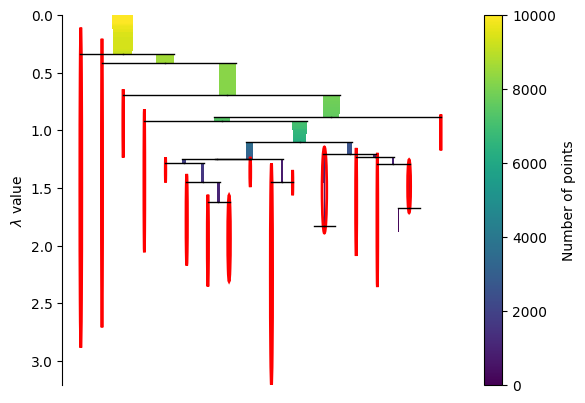

In [58]:
# Step 3 - Cluster Reduced Embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=120,
    min_samples=60,
    metric='euclidean',     # Default: euclidean
    # cluster_selection_method='leaf',     # "leaf", Default: eom
    # gen_min_span_tree=True,
    prediction_data=True    # This is needed to avoid an AttributeError when integrating with BERTopic
)

# Visualise the condensed tree (This is helpful to determine hyperparameters)
hdbscan_model.fit(u)
hdbscan_model.condensed_tree_.plot(select_clusters=True)

#### Step 4 - Tokenize and Vectorize topics

In [12]:
# Step 4 - Tokenize and Vectorize topics
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        # Tokenize
        tokens = word_tokenize(doc)

        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        # Remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # Lemmatize
        lemmas = [self.wnl.lemmatize(t) for t in words]
        
        return lemmas

# Remove stopwords and vectorize
stopwords = list(stopwords.words('english'))
vectorizer_model = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopwords)

#### Step 5 - Create Topic Representation

In [13]:
# Step 5 - Create Topic Representation
ctfidf_model = ClassTfidfTransformer()

#### Step 6 ...

In [14]:
# Step ...... 
representation_model = MaximalMarginalRelevance(diversity=0.2)

### Train Model

In [60]:
topic_model = BERTopic(
  embedding_model=embedding_model,            # Step 1 - Transform documents to Embeddings
  umap_model=umap_model,                      # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,          # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                  # Step 5 - Extract topic words
  representation_model=representation_model,  # Step 6 - Create topic representation
  # nr_topics=8,                                # Number of topics
  n_gram_range=(1, 1),                        # N-gram range
  top_n_words=10,                             # Number of words per topic
  language='english',
  calculate_probabilities=True,        
  verbose=True
)

topics, probs = topic_model.fit_transform(cleaned_dataset['content'])

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-03-24 02:50:37,417 - BERTopic - Transformed documents to Embeddings
2023-03-24 02:51:04,827 - BERTopic - Reduced dimensionality
2023-03-24 02:51:09,522 - BERTopic - Clustered reduced embeddings


In [45]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3970,-1_covid_lab_leak_pandemic
1,0,1467,0_covid_miss_wait_death
2,1,1087,1_vaccine_covid_wait_shot
3,2,697,2_pandemic_biden_wait_covid
4,3,624,3_technology_information_wait_covid
5,4,468,4_ending_covid_trump_pandemic
6,5,307,5_time_technology_information_covid
7,6,289,6_mask_covid_wear_study
8,7,271,7_china_lab_chinese_covid
9,8,235,8_fauci_dr_lab_trump


In [61]:
topic_model.visualize_barchart(top_n_topics=20)

In [62]:
topic_model.visualize_topics()

In [63]:
topic_model.visualize_heatmap()

In [20]:
topic_model.visualize_hierarchy()

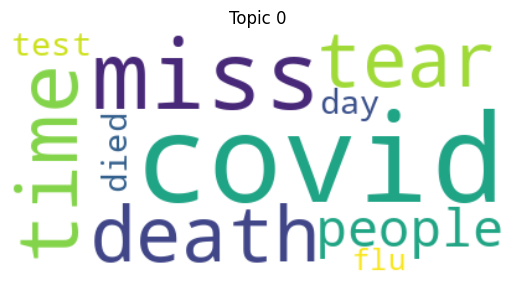

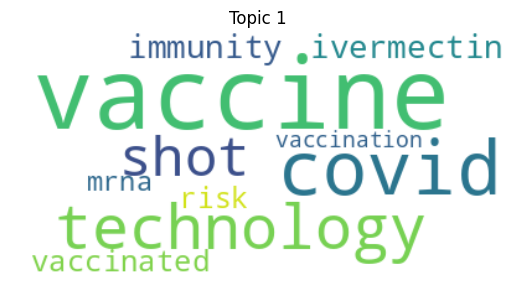

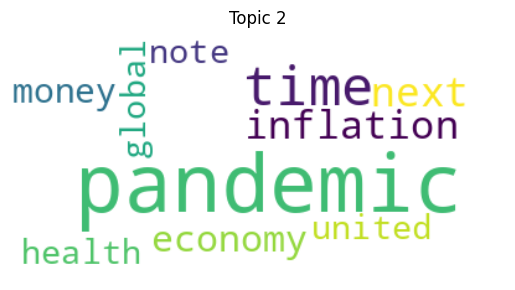

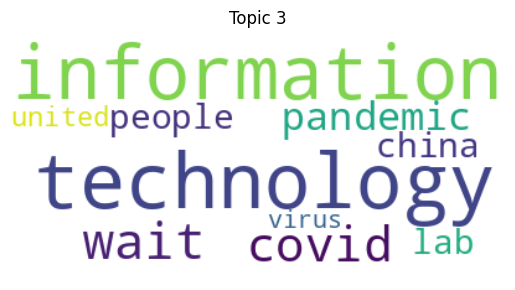

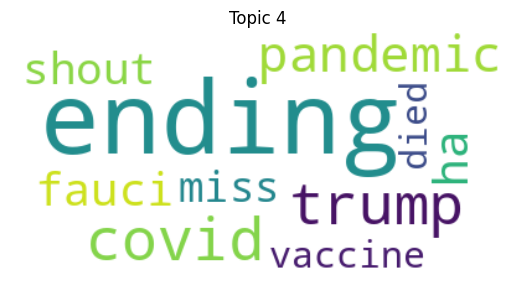

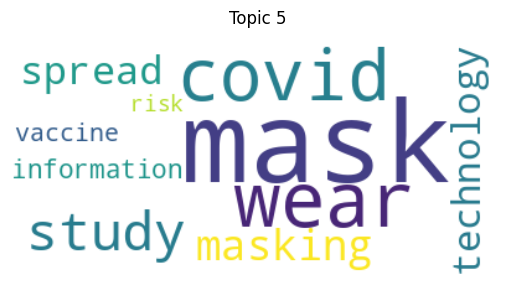

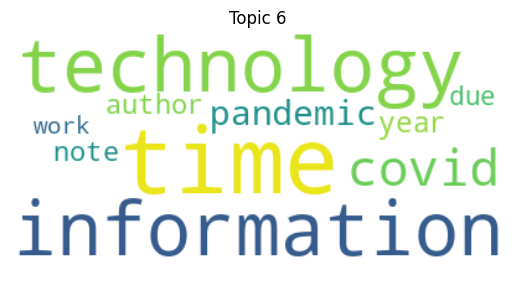

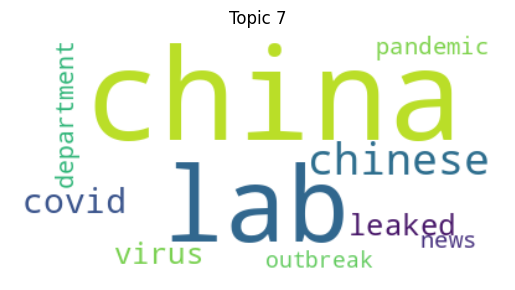

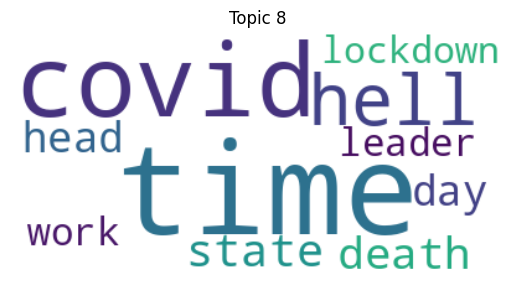

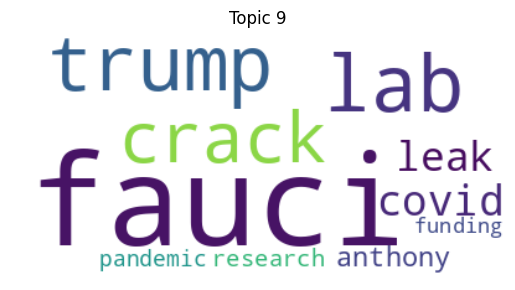

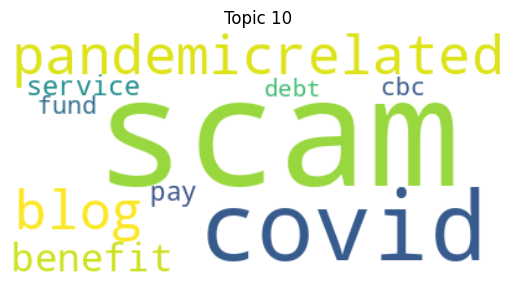

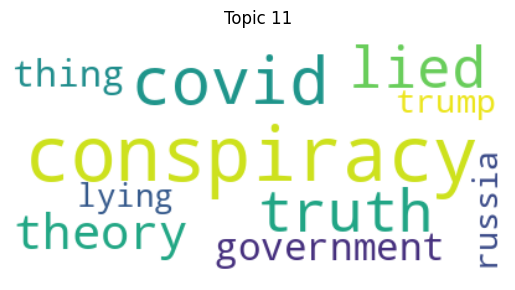

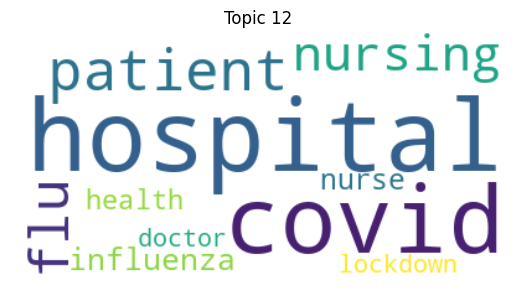

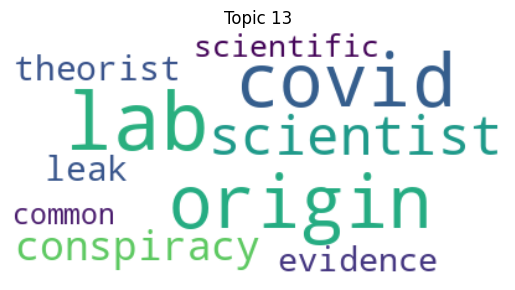

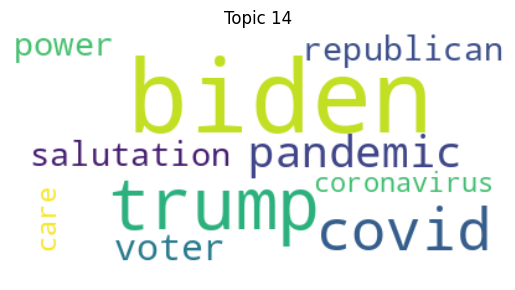

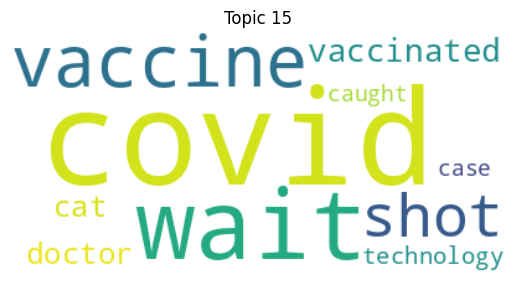

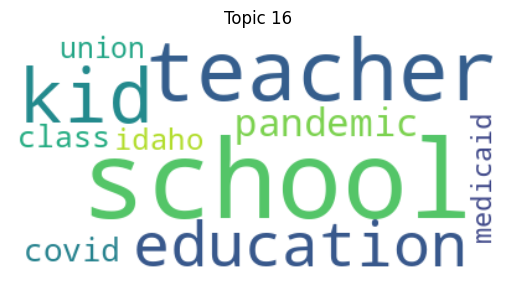

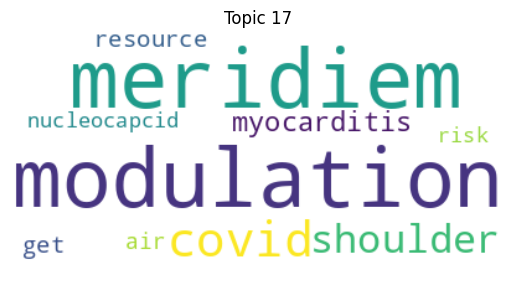

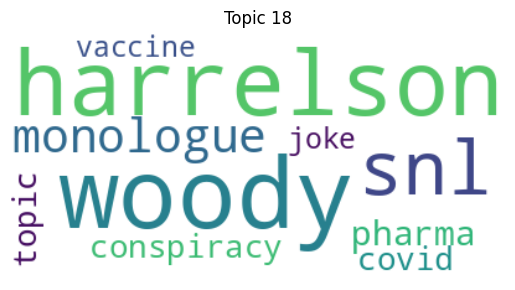

In [37]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    # Add title
    plt.title(f"Topic {topic}")
    plt.show()

# Show wordcloud
for i in range(len(topic_model.get_topic_info()) - 1):
    create_wordcloud(topic_model, topic=i)

THE END